In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.layers import Dense , LSTM, Dropout
from tensorflow.keras.layers import GRU
from keras.models import Sequential, load_model
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

In [ ]:
fd_001_train = pd.read_csv("/content/drive/MyDrive/CMaps/train_FD001.txt",sep=" ",header=None)

In [ ]:
fd_001_test = pd.read_csv("/content/drive/MyDrive/CMaps/test_FD001.txt",sep=" ",header=None)

In [ ]:
fd_001_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [ ]:
fd_001_train.drop(columns=[26,27],inplace=True)

In [ ]:
fd_001_test.drop(columns=[26,27],inplace=True)

In [ ]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [ ]:
fd_001_train.columns = columns

In [ ]:
fd_001_test.columns = columns

In [ ]:
#initial acquaintance with data
fd_001_train.describe()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [ ]:
#delete columns with constant values ​​that do not carry information about the state of the unit
fd_001_train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

## We will display the mutual correlations of the signs on the "heat map", for this we will prepare an additional sign "RUL", showing the number of cycles to failure in the training data

In [ ]:
#function for preparing training data and forming a RUL column with information about the remaining
# before breaking cycles
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    
    return df[df['time_in_cycles'] > factor]


In [ ]:
df = prepare_train_data(fd_001_train)

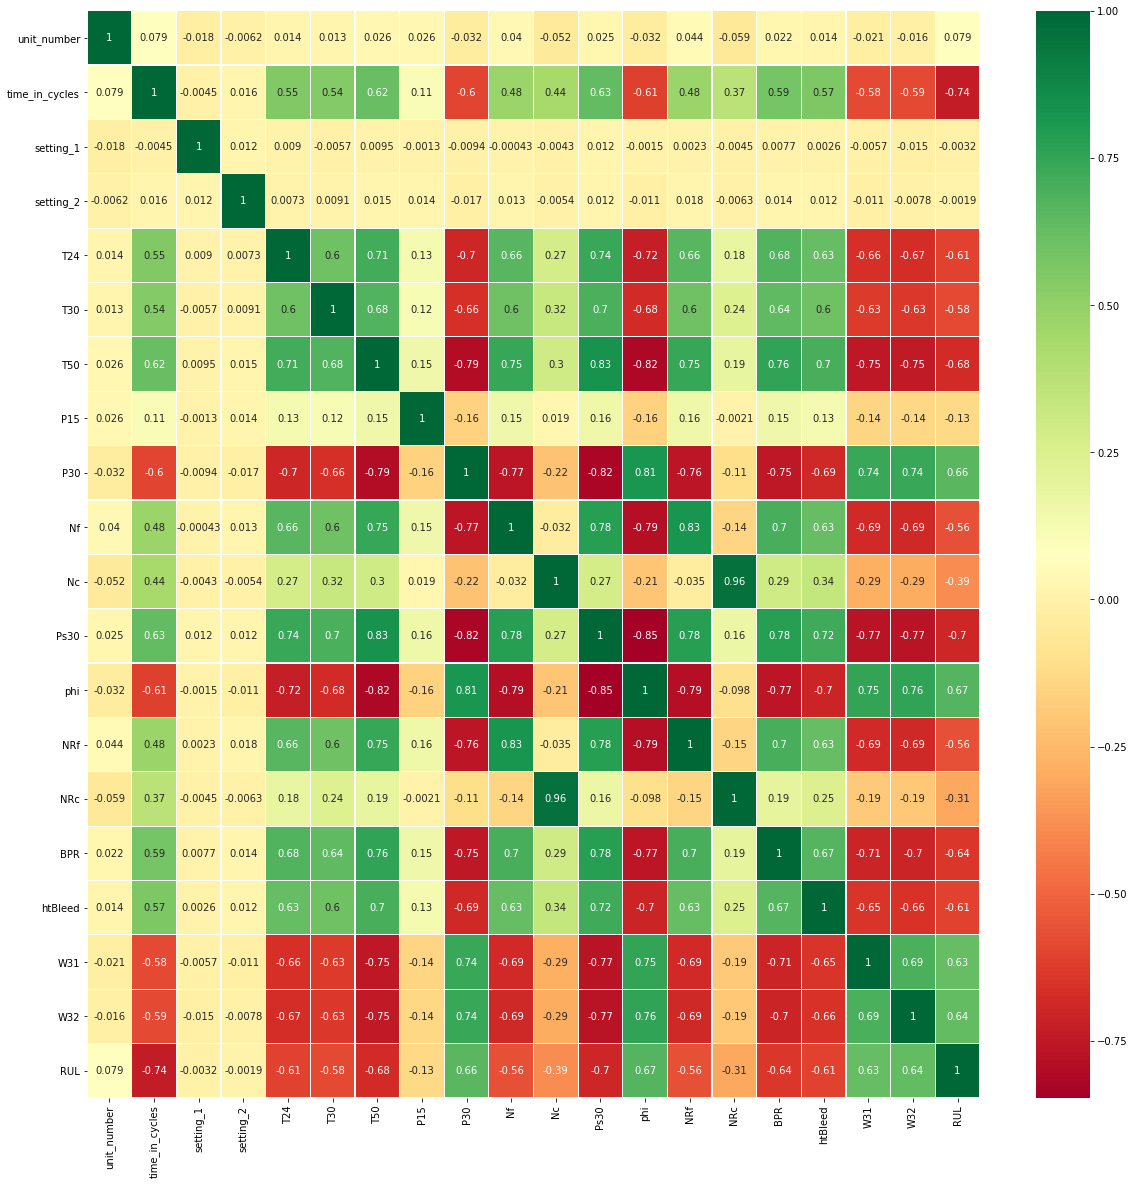

In [ ]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

## Error Function for Competitive Data

In [ ]:
#Error Function for Competitive Data
def score(y_true,y_pred,a1=10,a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

In [ ]:
def score_func(y_true,y_pred):
    lst = [round(score(y_true,y_pred),2), 
          round(mean_absolute_error(y_true,y_pred),2),
          round(mean_squared_error(y_true,y_pred),2)**0.5,
          round(r2_score(y_true,y_pred),2)]
    
    print(f' compatitive score {lst[0]}')
    print(f' mean absolute error {lst[1]}')
    print(f' root mean squared error {lst[2]}')
    print(f' R2 score {lst[3]}')
    return [lst[1], round(lst[2],2), lst[3]*100]
    

## We remove the properties that weakly correlate with the RUL target: setting_1, setting_2, P15, unit_number, as well as one of the features that are highly correlated with each other (Nc and NRc have a correlation coefficient of 0.96, remove NRc)

In [ ]:
unit_number = pd.DataFrame(df["unit_number"])
train_df = df.drop(columns = ['unit_number','setting_1','setting_2','P15','NRc'])

In [ ]:
train_df.head()

,time_in_cycles,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,BPR,htBleed,W31,W32,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


In [ ]:
RUL = pd.read_csv("/content/drive/MyDrive/CMaps/RUL_FD001.txt",sep=" ",header=None)

## Implementing LSTM

### Data Preprocessing for LSTM 

In [ ]:
def data_preprocessing(raw_train_data, raw_test_data, raw_RUL_data):
    train_df = raw_train_data
    truth_df = raw_RUL_data
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    
    #################
    # TRAIN 
    #################
    
    # we will only make use of "label1" for binary classification, 
    # while trying to answer the question: is a specific engine going to fail within w1 cycles?
    w1 = 30
    w0 = 15
    train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
    train_df['label2'] = train_df['label1']
    train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
    
    # MinMax normalization (from 0 to 1)
    train_df['cycle_norm'] = train_df['time_in_cycles']
    cols_normalize = train_df.columns.difference(['unit_number','time_in_cycles','RUL','label1','label2']) # NORMALIZE COLUMNS except [id , cycle, rul ....]

    min_max_scaler = MinMaxScaler()

    norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                                 columns=cols_normalize, 
                                 index=train_df.index)

    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
    train_df = join_df.reindex(columns = train_df.columns)
    print("train_df >> ",train_df.head())
    print("\n")

    
    #################
    # TEST
    #################
    
#     raw_test_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)
    test_df = raw_test_data.drop(columns = ['setting_1','setting_2','P15','NRc','max'])
    
    # MinMax normalization (from 0 to 1)
    test_df['cycle_norm'] = test_df['time_in_cycles']
    norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                                columns=cols_normalize, 
                                index=test_df.index)
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)
    
    # We use the ground truth dataset to generate labels for the test data.
    # generate column max for test data
    rul = pd.DataFrame(test_df.groupby('unit_number')['time_in_cycles'].max()).reset_index()
    rul.columns = ['unit_number','max']
    truth_df.columns = ['more']
    truth_df['unit_number'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more'] # adding true-rul vlaue + max cycle of test data set w.r.t MID
    truth_df.drop('more', axis=1, inplace=True)

    # generate RUL for test data
    test_df = test_df.merge(truth_df, on=['unit_number'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['time_in_cycles']
    test_df.drop('max', axis=1, inplace=True) 

    # generate label columns w0 and w1 for test data
    test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
    test_df['label2'] = test_df['label1']
    test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
    print("test_df >> ", test_df.head())

    
    ## pick a large window size of 50 cycles
    sequence_length = 50

    # function to reshape features into (samples, time steps, features) 
    def gen_sequence(id_df, seq_length, seq_cols):
        """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        # for one id I put all the rows in a single matrix
        data_matrix = id_df[seq_cols].values
        num_elements = data_matrix.shape[0]
        # Iterate over two lists in parallel.
        # For example id1 have 192 rows and sequence_length is equal to 50
        # so zip iterate over two following list of numbers (0,112),(50,192)
        # 0 50 -> from row 0 to row 50
        # 1 51 -> from row 1 to row 51
        # 2 52 -> from row 2 to row 52
        # ...
        # 111 191 -> from row 111 to 191
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_matrix[start:stop, :]

    # pick the feature columns 
    sequence_cols = list(test_df.columns[:-3])

    print(sequence_cols)
    
    # TODO for debug 
    # val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
    val=list(gen_sequence(train_df[train_df['unit_number']==1], sequence_length, sequence_cols))
    print(len(val))

    # generator for the sequences
    # transform each id of the train dataset in a sequence
    seq_gen = (list(gen_sequence(train_df[train_df['unit_number']==id], sequence_length, sequence_cols)) 
               for id in train_df['unit_number'].unique())

    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    print(seq_array.shape)

    # function to generate labels
    def gen_labels(id_df, seq_length, label):
        """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
        we need to drop those which are below the window-length. An alternative would be to pad sequences so that
        we can use shorter ones """
        # For one id I put all the labels in a single matrix.
        # For example:
        # [[1]
        # [4]
        # [1]
        # [5]
        # [9]
        # ...
        # [200]] 
        data_matrix = id_df[label].values
        num_elements = data_matrix.shape[0]
        # I have to remove the first seq_length labels
        # because for one id the first sequence of seq_length size have as target
        # the last label (the previus ones are discarded).
        # All the next id's sequences will have associated step by step one label as target.
        return data_matrix[seq_length:num_elements, :]

    # generate labels
    label_gen = [gen_labels(train_df[train_df['unit_number']==id], sequence_length, ['RUL']) 
                 for id in train_df['unit_number'].unique()]

    label_array = np.concatenate(label_gen).astype(np.float32)
    print(label_array.shape)
    print(label_array)
    
    return seq_array, label_array, test_df, sequence_length, sequence_cols

LSTM Model


In [ ]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def lstm_train(seq_array, label_array, sequence_length):
    # The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
    # Dropout is also applied after each LSTM layer to control overfitting. 
    # Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())

    # fit the network # Commoly used 100 epoches but 50-60 are fine its an early cutoff 
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2)
    #           callbacks = [keras.callbacks.EarlyStoping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
    #                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
    #           )

    # list all data in history
    print(history.history.keys())
    
    return model, history

Model Evaluation on Test set


In [ ]:
def test_evaluation_graphs(model, history, seq_array, label_array):
    # summarize history for R^2
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['r2_keras'])
    plt.plot(history.history['val_r2_keras'])
    plt.title('model r^2')
    plt.ylabel('R^2')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_r2.png")

    # summarize history for MAE
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_mae.png")

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_regression_loss.png")

    # training metrics
    scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
    print('\nMAE: {}'.format(scores[1]))
    print('\nR^2: {}'.format(scores[2]))

    y_pred = model.predict(seq_array,verbose=1, batch_size=200)
    y_true = label_array

    test_set = pd.DataFrame(y_pred )
    test_set.head()
    # test_set.to_csv('submit_train.csv', index = None)

Model Evaluation on Validation set

In [ ]:
def valid_evaluation(lstm_test_df, model, sequence_length, sequence_cols):
    # We pick the last sequence for each id in the test data
    seq_array_test_last = [lstm_test_df[lstm_test_df['unit_number']==id][sequence_cols].values[-sequence_length:] 
                           for id in lstm_test_df['unit_number'].unique() if len(lstm_test_df[lstm_test_df['unit_number']==id]) >= sequence_length]

    seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

    # Similarly, we pick the labels
    y_mask = [len(lstm_test_df[lstm_test_df['unit_number']==id]) >= sequence_length for id in lstm_test_df['unit_number'].unique()]
    label_array_test_last = lstm_test_df.groupby('unit_number')['RUL'].nth(-1)[y_mask].values
    label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

    estimator = model

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    print(test_set.head())

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test)
    plt.plot(y_true_test, color="orange")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    # fig_verify.savefig("model_regression_verify.png")
    return scores_test[1], scores_test[2]

### Function for creating and training models using the "Random forest" and "XGBoost" algorithms


In [ ]:
#function for creating and training models using the "Random forest" and "XGBoost" algorithms
def train_models(data,model = 'FOREST'):
    
    if (model != 'LSTM' and model != 'GRU'):
        X = data.iloc[:,:14].to_numpy() 
        Y = data.iloc[:,14:].to_numpy()
        Y = np.ravel(Y)

    if model == 'FOREST':
         #  parameters for models are selected in a similar cycle, with the introduction 
         # of an additional param parameter into the function:
         #for i in range(1,11):
         #     xgb = train_models(train_df,param=i,model="XGB",)
         #     y_xgb_i_pred = xgb.predict(X_001_test)
         #     print(f'param = {i}')
         #     score_func(y_true,y_xgb_i_pred)
        model = RandomForestRegressor(n_estimators=70, max_features=7, max_depth=5, n_jobs=-1, random_state=1)
        model.fit(X,Y)
        return model
    
    elif model == 'GRU':
        seq_array, label_array, gru_test_df, sequence_length, sequence_cols = data_preprocessing(data[0], data[1], data[2])
        model_instance, history = GRU_train(seq_array, label_array, sequence_length)
        return model_instance, history, gru_test_df, seq_array, label_array, sequence_length, sequence_cols
    
    elif model == 'LSTM':
        seq_array, label_array, lstm_test_df, sequence_length, sequence_cols = data_preprocessing(data[0], data[1], data[2])
        model_instance, history = lstm_train(seq_array, label_array, sequence_length)
        return model_instance, history, lstm_test_df, seq_array, label_array, sequence_length, sequence_cols
            
    return

In [ ]:
#function for joint display of real and predicted values

def plot_result(y_true,y_pred):
    rcParams['figure.figsize'] = 12,10
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('training samples')
    plt.legend(('Predicted', 'True'), loc='upper right')
    plt.title('COMPARISION OF Real and Predicted values')
    plt.show()
    return

# Prepare test data for classification
only the features used in the training are needed and a line with the maximum value for this engine time_in_cycles (last)

In [ ]:
fd_001_test.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [ ]:
test_max = fd_001_test.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns = ['unit_number','max']

In [ ]:
fd_001_test = fd_001_test.merge(test_max, on=['unit_number'], how='left')

In [ ]:
test = fd_001_test[fd_001_test['time_in_cycles'] == fd_001_test['max']].reset_index()

In [ ]:
test.drop(columns=['index','max','unit_number','setting_1','setting_2','P15','NRc'],inplace = True)

In [ ]:
X_001_test = test.to_numpy()

In [ ]:
X_001_test.shape

(100, 14)

In [ ]:
fd_001_test.head()

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,max
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,31
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,31
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,31
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,31
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,31


## Prediction of the final result for all engines


## Let's train the model on training data without the deleted properties 'unit_number', 'setting_1', 'setting_2', 'P15', 'NRc'

In [ ]:
model_1 = train_models(train_df)

In [ ]:
y_pred = model_1.predict(X_001_test)

In [ ]:
RUL = pd.read_csv("/content/drive/MyDrive/CMaps/RUL_FD001.txt",sep=" ",header=None)

In [ ]:
y_true = RUL[0].to_numpy()

In [ ]:
RUL.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


## Competitive score, the average absolute error, the root mean square error and the coefficient of determination of the resulting model:

In [ ]:
RF_individual_scorelst = score_func(y_true, y_pred)

 compatitive score 1057.2
 mean absolute error 19.25
 root mean squared error 24.45219826518671
 R2 score 0.65


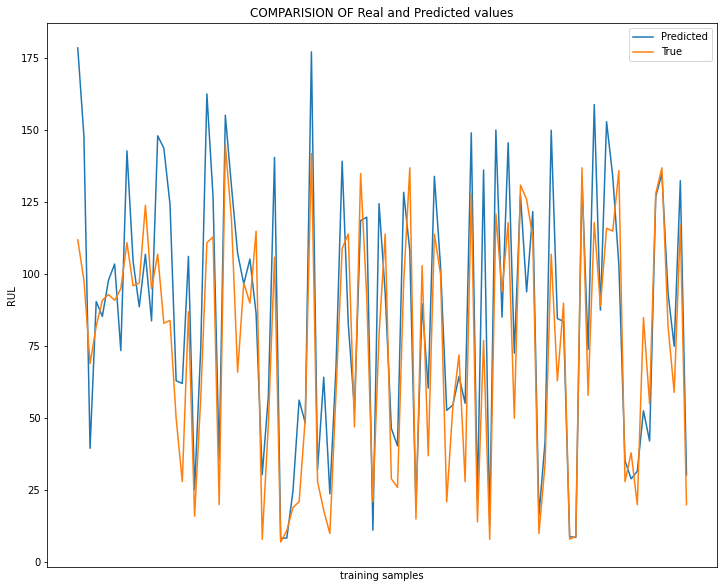

In [ ]:
plot_result(y_true,y_pred)

### LSTM funtion calling

In [ ]:
train_df_lstm = pd.concat([unit_number, train_df], axis=1)
model, history, lstm_test_df, seq_array, label_array, sequence_length, sequence_cols = train_models([train_df_lstm, fd_001_test, RUL.copy()], "LSTM")

train_df >>     unit_number  time_in_cycles       T24  ...  label1  label2  cycle_norm
0            1               1  0.183735  ...       0       0     0.00000
1            1               2  0.283133  ...       0       0     0.00277
2            1               3  0.343373  ...       0       0     0.00554
3            1               4  0.343373  ...       0       0     0.00831
4            1               5  0.349398  ...       0       0     0.01108

[5 rows x 19 columns]


test_df >>     unit_number  time_in_cycles       T24  ...  RUL  label1  label2
0            1               1  0.545181  ...  142       0       0
1            1               2  0.150602  ...  141       0       0
2            1               3  0.376506  ...  140       0       0
3            1               4  0.370482  ...  139       0       0
4            1               5  0.391566  ...  138       0       0

[5 rows x 19 columns]
['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30',

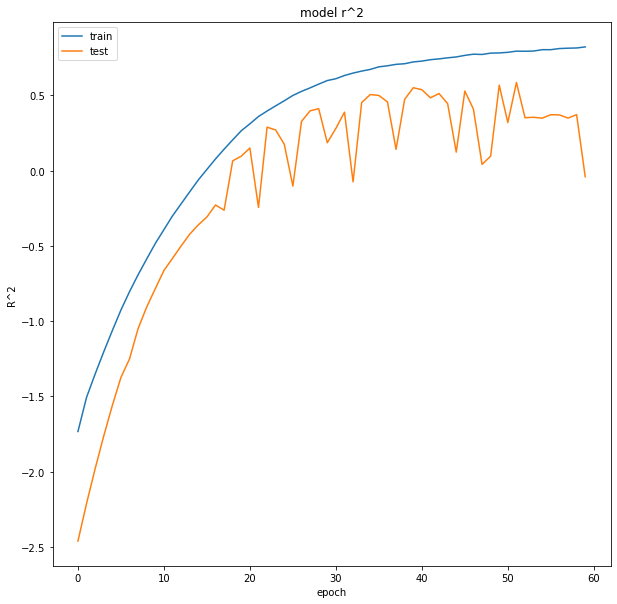

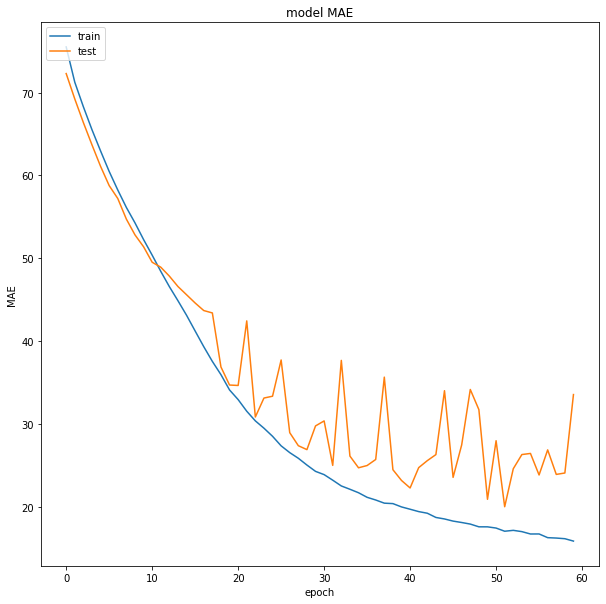

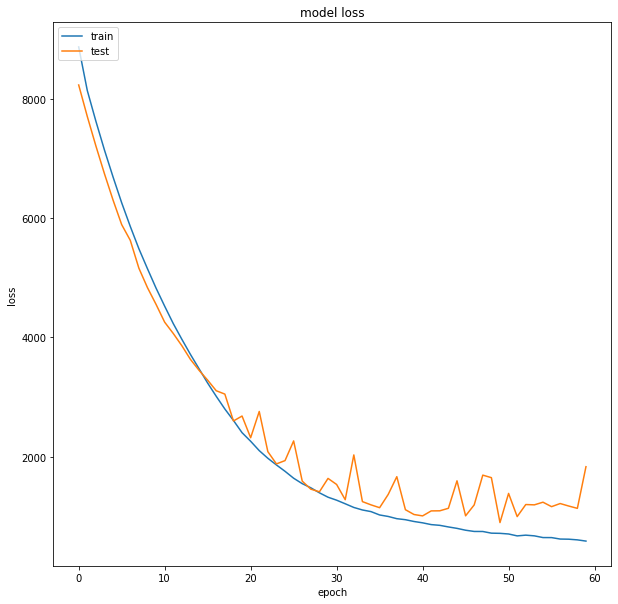

79/79 [==============================] - 1s 13ms/step - loss: 798.2245 - mae: 20.5713 - r2_keras: 0.6272

MAE: 20.57129669189453

R^2: 0.6271857023239136
79/79 [==============================] - 2s 10ms/step


In [ ]:
test_evaluation_graphs(model, history, seq_array, label_array)

3/3 - 0s - loss: 949.5232 - mae: 22.6950 - r2_keras: 0.4420

MAE: 22.69503402709961

R^2: 0.44202807545661926
            0
0   59.869900
1   77.084961
2   82.813240
3   77.940025
4  108.092949


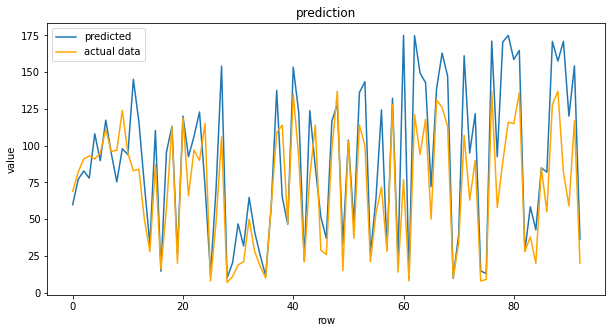

In [ ]:
MAE, R2 = valid_evaluation(lstm_test_df, model, sequence_length, sequence_cols)
# mae, rmse, r2
LSTM_individual_scorelst = [round(MAE,2), 0, round(R2,2)*100]

### GRU function calling


In [ ]:
def GRU_train(seq_array, label_array, sequence_length):
    
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(GRU(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
    model.build((0,sequence_length, nb_features))
    print(model.summary())

    # fit the network # Commoly used 100 epoches but 50-60 are fine its an early cutoff 
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2)
    #           callbacks = [keras.callbacks.EarlyStoping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
    #                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
    #           )

    # list all data in history
    print(history.history.keys())
    
    return model, history

In [ ]:
train_df_gru = pd.concat([unit_number, train_df], axis=1)
model, history, gru_test_df, seq_array, label_array, sequence_length, sequence_cols = train_models([train_df_gru, fd_001_test, RUL.copy()], "GRU")

train_df >>     unit_number  time_in_cycles       T24  ...  label1  label2  cycle_norm
0            1               1  0.183735  ...       0       0     0.00000
1            1               2  0.283133  ...       0       0     0.00277
2            1               3  0.343373  ...       0       0     0.00554
3            1               4  0.343373  ...       0       0     0.00831
4            1               5  0.349398  ...       0       0     0.01108

[5 rows x 19 columns]


test_df >>     unit_number  time_in_cycles       T24  ...  RUL  label1  label2
0            1               1  0.545181  ...  142       0       0
1            1               2  0.150602  ...  141       0       0
2            1               3  0.376506  ...  140       0       0
3            1               4  0.370482  ...  139       0       0
4            1               5  0.391566  ...  138       0       0

[5 rows x 19 columns]
['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30',

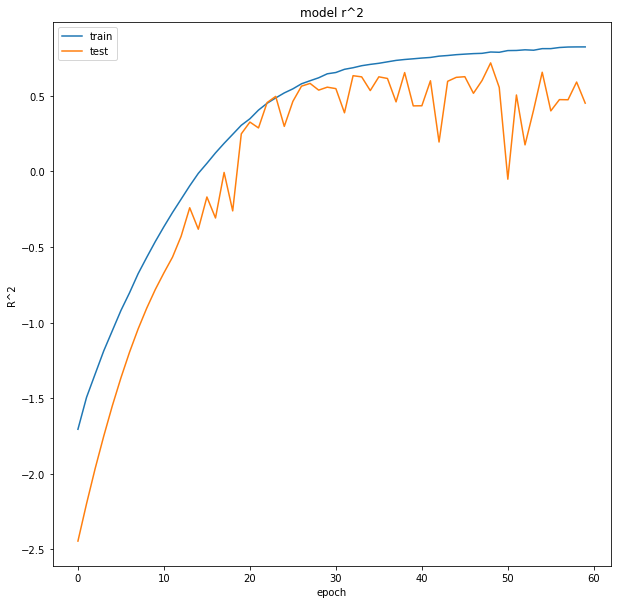

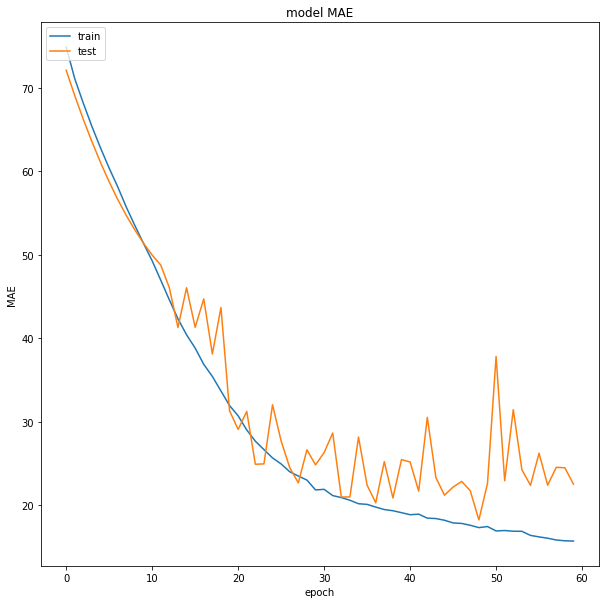

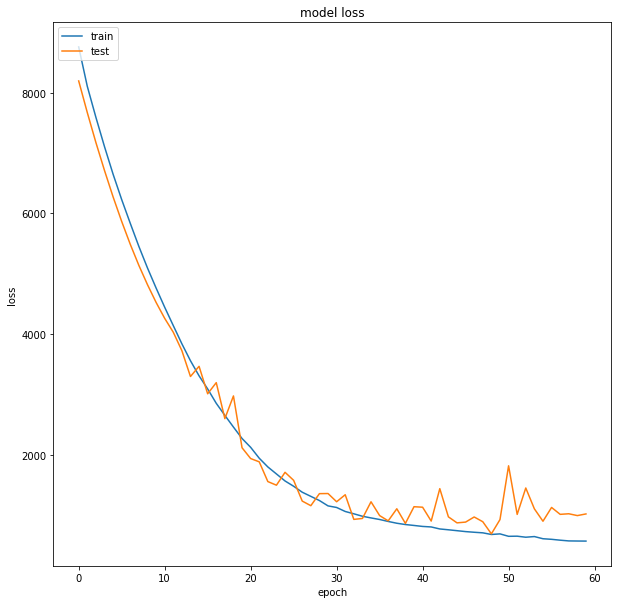

79/79 [==============================] - 1s 9ms/step - loss: 424.2432 - mae: 12.0868 - r2_keras: 0.8455

MAE: 12.086820602416992

R^2: 0.8455440402030945
79/79 [==============================] - 1s 8ms/step


In [ ]:
test_evaluation_graphs(model, history, seq_array, label_array)

3/3 - 0s - loss: 708.9458 - mae: 18.4524 - r2_keras: 0.5738

MAE: 18.45237159729004

R^2: 0.5738036036491394
            0
0   72.663300
1   90.107910
2   94.124901
3   80.723984
4  104.797348


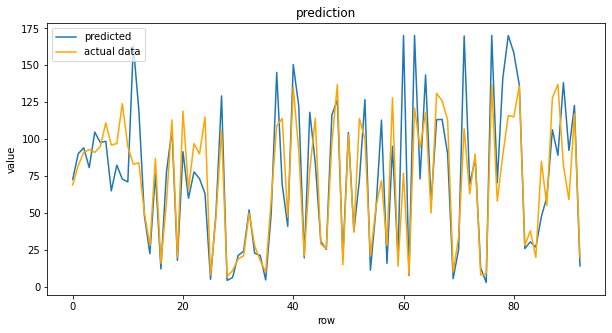

In [ ]:
MAE, R2 = valid_evaluation(gru_test_df, model, sequence_length, sequence_cols)
# mae, rmse, r2
LSTM_individual_scorelst = [round(MAE,2), 0, round(R2,2)*100]